Library installation and import

In [1]:
%pip install requests
%pip install fastai
%pip install os-sys

#@title Install the required libs
%pip install -U -qq git+https://github.com/huggingface/diffusers.git
%pip install -qq accelerate transformers ftfy

#@title [Optional] Install xformers for faster and memory efficient training
#@markdown Acknowledgement: The xformers wheel are taken from [TheLastBen/fast-stable-diffusion](https://github.com/TheLastBen/fast-stable-diffusion). Thanks a lot for building these wheels!

%pip install -U --pre triton

Note: you may need to restart the kernel to use updated packages.
INFO: pip is looking at multiple versions of matplotlib to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of pandas to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of scikit-learn to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of scipy to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.5/31.5 MB 130.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 795.1/795.1 kB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 96.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 146.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
import argparse
import itertools
import math
import os
import random

import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from torch.utils.data import Dataset

import PIL
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.optimization import get_scheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

from subprocess import getoutput
from IPython.display import HTML
from IPython.display import clear_output
import time

import requests
import matplotlib.pyplot as plt
from glob import glob

import shutil

In [ ]:
#@title [Optional] Login to the Hugging Face Hub
#@markdown Add a token with the "Write Access" role to be able to add your trained concept to the [Library of Concepts](https://huggingface.co/sd-concepts-library)
from huggingface_hub import notebook_login

notebook_login()

Token has not been saved to git credential helper.


In [4]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [5]:
%%time
s = getoutput('nvidia-smi')
if 'T4' in s:
  gpu = 'T4'
elif 'P100' in s:
  gpu = 'P100'
elif 'V100' in s:
  gpu = 'V100'
elif 'A100' in s:
  gpu = 'A100'

while True:
    try: 
        gpu=='T4'or gpu=='P100'or gpu=='V100'or gpu=='A100'
        break
    except:
        pass
    print('[1;31mit seems that your GPU is not supported at the moment')
    time.sleep(5)

if (gpu=='T4'):
  %pip install -q https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/T4/xformers-0.0.13.dev0-py3-none-any.whl
  
elif (gpu=='P100'):
  %pip install -q https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/P100/xformers-0.0.13.dev0-py3-none-any.whl

elif (gpu=='V100'):
  %pip install -q https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/V100/xformers-0.0.13.dev0-py3-none-any.whl

elif (gpu=='A100'):
  %pip install -q https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/A100/xformers-0.0.13.dev0-py3-none-any.whl

  ERROR: HTTP error 404 while getting https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/T4/xformers-0.0.13.dev0-py3-none-any.whl
ERROR: Could not install requirement xformers==0.0.13.dev0 from https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/T4/xformers-0.0.13.dev0-py3-none-any.whl because of HTTP error 404 Client Error: Not Found for url: https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/T4/xformers-0.0.13.dev0-py3-none-any.whl for URL https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/T4/xformers-0.0.13.dev0-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.
CPU times: user 5.53 ms, sys: 27 ms, total: 32.6 ms
Wall time: 1.46 s


Dataset download

In [5]:
def download_specific_characters(character_ids):
    """Download specific character datasets by their ID numbers"""

    base_url = "https://huggingface.co/datasets/BangumiBase/onepiece/resolve/main"

    for char_id in character_ids:
        url = f"{base_url}/{char_id}/dataset.zip"
        filename = f"character_{char_id}.zip"

        print(f"Downloading character {char_id}...")
        response = requests.get(url, stream=True)

        if response.status_code == 200:
            with open(filename, "wb") as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            print(f"Downloaded {filename}")
        else:
            print(f"Failed to download character {char_id}")


In [ ]:
download_specific_characters([2,7,8,12,14,63,29,33,34,35,55,56,60,65,69,125,126,149])

In [ ]:
%%time
# Create character directories:
!mkdir -p chopper
!mkdir -p franky
!mkdir -p god_usopp
!mkdir -p luffy
!mkdir -p nami
!mkdir -p robin
!mkdir -p sanji
!mkdir -p sabo
!mkdir -p shanks
!mkdir -p zoro

# Unzip commands:
!unzip character_2.zip -d shanks
!unzip character_7.zip -d luffy
!unzip character_8.zip -d luffy
!unzip character_12.zip -d god_usopp
!unzip character_14.zip -d god_usopp
!unzip character_29.zip -d zoro
!unzip character_33.zip -d sanji
!unzip character_34.zip -d sanji
!unzip character_35.zip -d sanji
!unzip character_55.zip -d chopper
!unzip character_56.zip -d chopper
!unzip character_60.zip -d franky
!unzip character_63.zip -d luffy
!unzip character_65.zip -d robin
!unzip character_69.zip -d robin
!unzip character_125.zip -d nami
!unzip character_126.zip -d nami
!unzip character_149.zip -d sabo

In [6]:
!mkdir -p chopper
!mkdir -p franky
!mkdir -p god_usopp
!mkdir -p luffy
!mkdir -p nami
!mkdir -p robin
!mkdir -p sanji
!mkdir -p sabo
!mkdir -p shanks
!mkdir -p zoro

In [ ]:
def quick_preview(character_folder, num_images=9):
    """Quick 3x3 grid preview"""
    import glob
    
    image_files = []
    for ext in ['*.jpg', '*.jpeg', '*.png', '*.webp']:
        image_files.extend(glob.glob(os.path.join(character_folder, ext)))
    
    if not image_files:
        print(f"No images found in {character_folder}")
        return
    
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    fig.suptitle(f'{character_folder.title()} - {len(image_files)} total images')
    
    for i in range(9):
        row, col = i // 3, i % 3
        if i < len(image_files):
            img = Image.open(image_files[i])
            axes[row, col].imshow(img)
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()
    print(f"Total images in {character_folder}: {len(image_files)}")

# Quick preview all characters
for character in ['shanks', 'luffy', 'zoro', 'sanji','franky','nami','robin','sabo','god_usopp']:
    quick_preview(character)

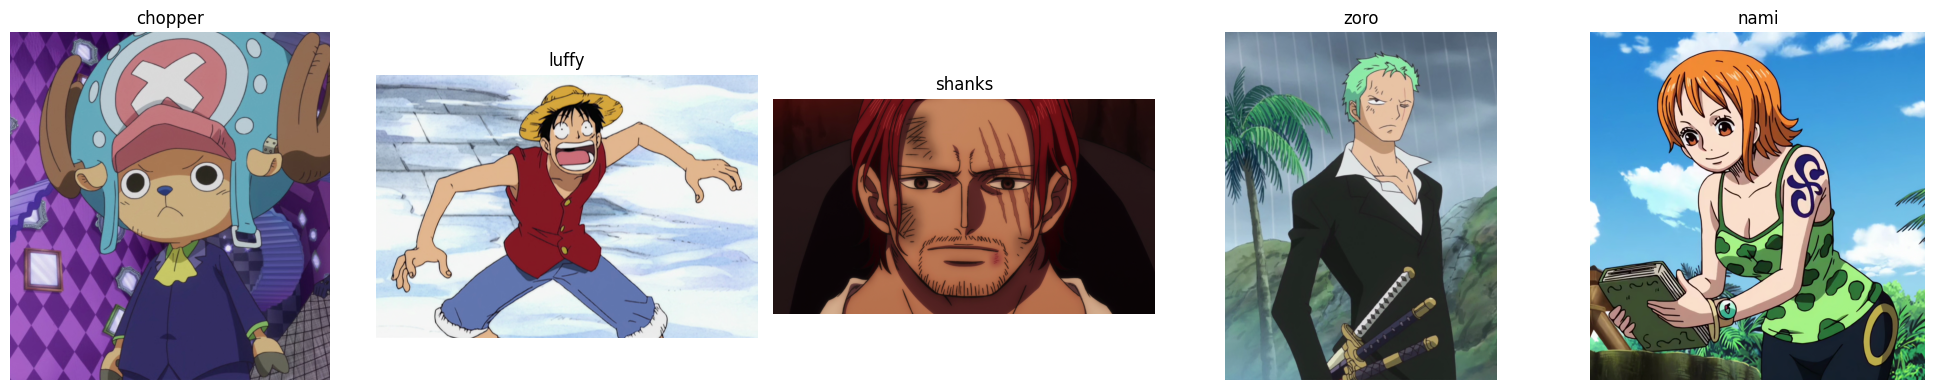

In [7]:
# --- Helpers used in show_image ---
def hasattrs(obj, attrs): return all(hasattr(obj, attr) for attr in attrs)
def array(x): return np.array(x)
def ifnone(a, b): return b if a is None else a
def _fig_bounds(x): return min(10, max(3, x // 20))

# --- show_image function ---
def show_image(im, ax=None, figsize=None, title=None, ctx=None, **kwargs):
    if hasattrs(im, ('data','cpu','permute')):
        im = im.data.cpu()
        if im.shape[0]<5: im=im.permute(1,2,0)
    elif not isinstance(im, np.ndarray): im = array(im)
    if im.shape[-1] == 1: im = im[..., 0]

    ax = ifnone(ax, ctx)
    if figsize is None: figsize = (_fig_bounds(im.shape[0]), _fig_bounds(im.shape[1]))
    if ax is None: _, ax = plt.subplots(figsize=figsize)
    ax.imshow(im, **kwargs)
    if title is not None: ax.set_title(title)
    ax.axis('off')
    return ax

# --- Image folders list ---
# folders = [
#    "./chopper", "./robin", "./franky", "./sabo", "./god_usopp",
#    "./sanji", "./luffy", "./shanks", "./zoro"
#]

folders = [
    "./chopper",  "./luffy", "./shanks", "./zoro", "./nami"
]


# --- Collect image paths (e.g. only first image from each folder) ---
image_paths = []
for folder in folders:
    imgs = glob(os.path.join(folder, "*.jpg")) + glob(os.path.join(folder, "*.png"))
    if imgs:
        image_paths.append(imgs[0])  # pick the first image from each folder

# --- Display the images ---
n = len(image_paths)
fig, axs = plt.subplots(1, n, figsize=(n * 4, 4))

# Ensure axs is iterable even if n==1
if n == 1:
    axs = [axs]

for ax, path in zip(axs, image_paths):
    im = Image.open(path)
    title = os.path.basename(os.path.dirname(path))  # folder name as title
    show_image(im, ax=ax, title=title)

plt.tight_layout()
plt.show()


# Textual Inversion

Settings for teaching your new concept

In [8]:
#@markdown `pretrained_model_name_or_path` which Stable Diffusion checkpoint you want to use
#@markdown `pretrained_model_name_or_path` which Stable Diffusion checkpoint you want to use
pretrained_model_name_or_path = "stabilityai/stable-diffusion-2" #@param ["stabilityai/stable-diffusion-2", "stabilityai/stable-diffusion-2-base", "CompVis/stable-diffusion-v1-4", "runwayml/stable-diffusion-v1-5"] {allow-input: true}

## Load images from local folder

In [9]:
# Method 1: Specify multiple image paths directly
image_folders = [
   "./chopper",  "./luffy", "./shanks", "./zoro", "./nami"
]

# Create a combined directory for all images
combined_save_path = "./combined_concept_images"
os.makedirs(combined_save_path, exist_ok=True)

# Copy all images from multiple folders to the combined directory
image_count = 0
for folder_path in image_folders:
   if os.path.exists(folder_path):
       print(f"Processing folder: {folder_path}")
       for file_name in os.listdir(folder_path):
           file_path = os.path.join(folder_path, file_name)
           try:
               # Test if it's a valid image
               with Image.open(file_path) as img:
                   # Copy with a unique name to avoid conflicts
                   new_name = f"image_{image_count}_{file_name}"
                   new_path = os.path.join(combined_save_path, new_name)
                   shutil.copy2(file_path, new_path)
                   image_count += 1
                   print(f"Copied: {file_name}")
           except Exception as e:
               print(f"Skipped {file_name}: Not a valid image")
   else:
       print(f"Folder does not exist: {folder_path}")

print(f"Total images collected: {image_count}")
save_path = combined_save_path

Processing folder: ./chopper
Copied: 36726.png
Copied: 35046.png
Processing folder: ./luffy
Copied: 11083.png
Copied: 10181.png
Copied: 52005.png
Processing folder: ./shanks
Copied: 51128.png
Copied: 23015.png
Processing folder: ./zoro
Copied: 32347.png
Copied: 24647.png
Processing folder: ./nami
Copied: 52079.png
Copied: 52378.png
Total images collected: 11


In [11]:
#Here we load 1 just image from each of the folders, using many images to train increases the training complexity and cost
# Method 1: Specify multiple image paths directly

image_folders = [
   "./chopper",
   "./robin", 
   "./franky",
   "./luffy",
   "./shanks",
   "./zoro"
]

# Create a combined directory for all images
combined_save_path = "./combined_concept_images"
os.makedirs(combined_save_path, exist_ok=True)

# Copy 1 random image from each folder to the combined directory
image_count = 0
for folder_path in image_folders:
   if os.path.exists(folder_path):
       print(f"Processing folder: {folder_path}")
       
       # First, get all valid image files from the folder
       valid_images = []
       for file_name in os.listdir(folder_path):
           file_path = os.path.join(folder_path, file_name)
           try:
               # Test if it's a valid image
               with Image.open(file_path) as img:
                   valid_images.append(file_name)
           except Exception:
               continue  # Skip invalid images
       
       # If we found valid images, randomly select one
       if valid_images:
           selected_image = random.choice(valid_images)
           source_path = os.path.join(folder_path, selected_image)
           
           # Copy with a unique name to avoid conflicts
           folder_name = os.path.basename(folder_path)
           new_name = f"{folder_name}_{selected_image}"
           new_path = os.path.join(combined_save_path, new_name)
           
           shutil.copy2(source_path, new_path)
           image_count += 1
           print(f"Randomly selected and copied: {selected_image}")
       else:
           print(f"No valid images found in: {folder_path}")
   else:
       print(f"Folder does not exist: {folder_path}")

print(f"Total images collected: {image_count}")

# Display the selected images
save_path = combined_save_path

Processing folder: ./chopper
Randomly selected and copied: 35046.png
Folder does not exist: ./robin
Processing folder: ./franky
No valid images found in: ./franky
Processing folder: ./luffy
Randomly selected and copied: 10181.png
Processing folder: ./shanks
Randomly selected and copied: 23015.png
Processing folder: ./zoro
Randomly selected and copied: 32347.png
Total images collected: 4


### Setup and check the images you have just added

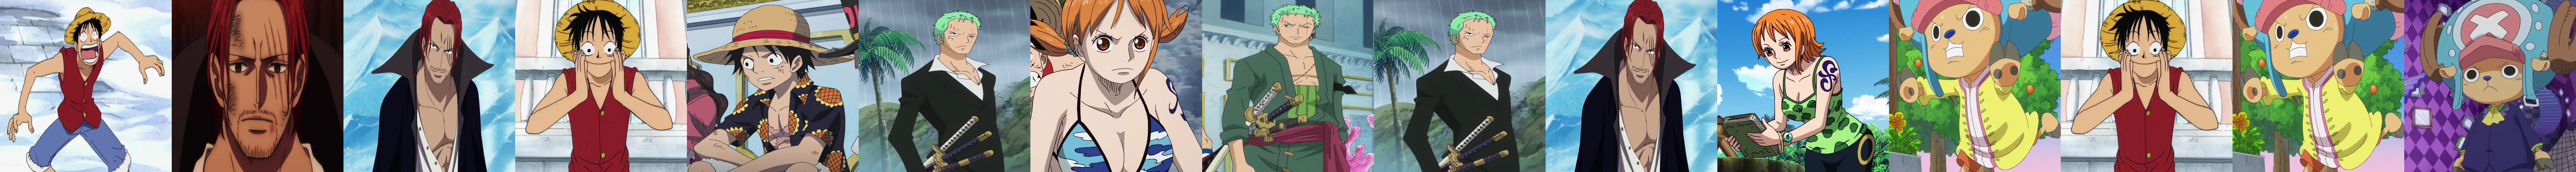

In [12]:
images = []
for file_path in os.listdir(save_path):
  try:
      image_path = os.path.join(save_path, file_path)
      images.append(Image.open(image_path).resize((512, 512)))
  except:
    print(f"{image_path} is not a valid image, please make sure to remove this file from the directory otherwise the training could fail.")
image_grid(images, 1, len(images))

In [8]:
# Just validate files without loading them into memory
valid_count = 0
invalid_files = []

print("Validating training images...")
for file_path in os.listdir(save_path):
    try:
        image_path = os.path.join(save_path, file_path)
        # Just open and immediately close - don't store in memory
        with Image.open(image_path) as img:
            if img.size[0] > 0 and img.size[1] > 0:  # Basic validation
                valid_count += 1
                if valid_count <= 5:  # Only print first 5
                    print(f"✓ {file_path}: {img.size}")
    except Exception as e:
        invalid_files.append(file_path)
        print(f"✗ Invalid: {file_path}")

print(f"\nValidation complete: {valid_count} valid images")
if invalid_files:
    print(f"Invalid files to remove: {invalid_files}")

# Set empty list for compatibility with later code
images = []

Validating training images...


✓ image_0_10026.png: (423, 538)
✓ image_10000_562.png: (638, 894)
✓ image_10001_5625.png: (511, 480)
✓ image_10002_5627.png: (493, 479)
✓ image_10003_563.png: (1388, 1080)

Validation complete: 12743 valid images


In [20]:
#@title Settings for your newly created concept
#@markdown `what_to_teach`: what is it that you are teaching? `object` enables you to teach the model a new object to be used, `style` allows you to teach the model a new style one can use.
what_to_teach = "style" #@param ["object", "style"]
#@markdown `placeholder_token` is the token you are going to use to represent your new concept (so when you prompt the model, you will say "A `<my-placeholder-token>` in an amusement park"). We use angle brackets to differentiate a token from other words/tokens, to avoid collision.
placeholder_token = "<one-piece-styling>" #@param {type:"string"}
#@markdown `initializer_token` is a word that can summarise what your new concept is, to be used as a starting point
initializer_token = "OnePiece" #@param {type:"string"}

### Teach the model a new concept (fine-tuning with textual inversion)

Execute this this sequence of cells to run the training process. The whole process may take from 1-4 hours. 

#### Create dataset

In [14]:
#@title Setup the prompt templates for training 
imagenet_templates_small = [
    "a photo of a {}",
    "a rendering of a {}",
    "a cropped photo of the {}",
    "the photo of a {}",
    "a photo of a clean {}",
    "a photo of a dirty {}",
    "a dark photo of the {}",
    "a photo of my {}",
    "a photo of the cool {}",
    "a close-up photo of a {}",
    "a bright photo of the {}",
    "a cropped photo of a {}",
    "a photo of the {}",
    "a good photo of the {}",
    "a photo of one {}",
    "a close-up photo of the {}",
    "a rendition of the {}",
    "a photo of the clean {}",
    "a rendition of a {}",
    "a photo of a nice {}",
    "a good photo of a {}",
    "a photo of the nice {}",
    "a photo of the small {}",
    "a photo of the weird {}",
    "a photo of the large {}",
    "a photo of a cool {}",
    "a photo of a small {}",
]

imagenet_style_templates_small = [
    "a painting in the style of {}",
    "a rendering in the style of {}",
    "a cropped painting in the style of {}",
    "the painting in the style of {}",
    "a clean painting in the style of {}",
    "a dirty painting in the style of {}",
    "a dark painting in the style of {}",
    "a picture in the style of {}",
    "a cool painting in the style of {}",
    "a close-up painting in the style of {}",
    "a bright painting in the style of {}",
    "a cropped painting in the style of {}",
    "a good painting in the style of {}",
    "a close-up painting in the style of {}",
    "a rendition in the style of {}",
    "a nice painting in the style of {}",
    "a small painting in the style of {}",
    "a weird painting in the style of {}",
    "a large painting in the style of {}",
]

In [15]:
#@title Setup the dataset
class TextualInversionDataset(Dataset):
    def __init__(
        self,
        data_root,
        tokenizer,
        learnable_property="style",  # [object, style]
        size=512,
        repeats=100,
        interpolation="bicubic",
        flip_p=0.5,
        set="train",
        placeholder_token="*",
        center_crop=False,
    ):

        self.data_root = data_root
        self.tokenizer = tokenizer
        self.learnable_property = learnable_property
        self.size = size
        self.placeholder_token = placeholder_token
        self.center_crop = center_crop
        self.flip_p = flip_p

        self.image_paths = [os.path.join(self.data_root, file_path) for file_path in os.listdir(self.data_root)]

        self.num_images = len(self.image_paths)
        self._length = self.num_images

        if set == "train":
            self._length = self.num_images * repeats

        self.interpolation = {
            "linear": PIL.Image.LINEAR,
            "bilinear": PIL.Image.BILINEAR,
            "bicubic": PIL.Image.BICUBIC,
            "lanczos": PIL.Image.LANCZOS,
        }[interpolation]

        self.templates = imagenet_style_templates_small if learnable_property == "style" else imagenet_templates_small
        self.flip_transform = transforms.RandomHorizontalFlip(p=self.flip_p)

    def __len__(self):
        return self._length

    def __getitem__(self, i):
        example = {}
        image = Image.open(self.image_paths[i % self.num_images])

        if not image.mode == "RGB":
            image = image.convert("RGB")

        placeholder_string = self.placeholder_token
        text = random.choice(self.templates).format(placeholder_string)

        example["input_ids"] = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
            return_tensors="pt",
        ).input_ids[0]

        # default to score-sde preprocessing
        img = np.array(image).astype(np.uint8)

        if self.center_crop:
            crop = min(img.shape[0], img.shape[1])
            h, w, = (
                img.shape[0],
                img.shape[1],
            )
            img = img[(h - crop) // 2 : (h + crop) // 2, (w - crop) // 2 : (w + crop) // 2]

        image = Image.fromarray(img)
        image = image.resize((self.size, self.size), resample=self.interpolation)

        image = self.flip_transform(image)
        image = np.array(image).astype(np.uint8)
        image = (image / 127.5 - 1.0).astype(np.float32)

        example["pixel_values"] = torch.from_numpy(image).permute(2, 0, 1)
        return example

#### Setting up the model

Below we set up our tokenizer

In [18]:
#@title Load the tokenizer and add the placeholder token as a additional special token.
tokenizer = CLIPTokenizer.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="tokenizer",
)

# Add the placeholder token in tokenizer
num_added_tokens = tokenizer.add_tokens(placeholder_token)
if num_added_tokens == 0:
    raise ValueError(
        f"The tokenizer already contains the token {placeholder_token}. Please pass a different"
        " `placeholder_token` that is not already in the tokenizer."
    )

In [21]:
#@title Get token ids for our placeholder and initializer token. This code block will complain if initializer string is not a single token
# Convert the initializer_token, placeholder_token to ids
token_ids = tokenizer.encode(initializer_token, add_special_tokens=False)
# Check if initializer_token is a single token or a sequence of tokens
if len(token_ids) > 1:
    raise ValueError("The initializer token must be a single token.")

initializer_token_id = token_ids[0]
placeholder_token_id = tokenizer.convert_tokens_to_ids(placeholder_token)

#### Load the Stable Diffusion model

Load models and create wrapper for stable diffusion

```pipeline = StableDiffusionPipeline.from_pretrained(pretrained_model_name_or_path)```


```del pipeline```

In [22]:
#@title Load the Stable Diffusion model
# Load models and create wrapper for stable diffusion
# pipeline = StableDiffusionPipeline.from_pretrained(pretrained_model_name_or_path)
# del pipeline
text_encoder = CLIPTextModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="text_encoder"
)
vae = AutoencoderKL.from_pretrained(
    pretrained_model_name_or_path, subfolder="vae"
)
unet = UNet2DConditionModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="unet"
)

config.json:   0%|          | 0.00/633 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/909 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

We can now resize our token embeddings to include our newly added placeholder_token. We have added the placeholder_token in the tokenizer so we resize the token embeddings here, this will a new embedding vector in the token embeddings for our placeholder_token

In [23]:
text_encoder.resize_token_embeddings(len(tokenizer))

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Embedding(49409, 1024)

Initialise the newly added placeholder token with the embeddings of the initializer token instead of random initialization.

In [25]:
token_embeds = text_encoder.get_input_embeddings().weight.data
token_embeds[placeholder_token_id] = token_embeds[initializer_token_id]

In [26]:
def freeze_params(params):
    for param in params:
        param.requires_grad = False

# Freeze vae and unet
freeze_params(vae.parameters())
freeze_params(unet.parameters())
# Freeze all parameters except for the token embeddings in text encoder
params_to_freeze = itertools.chain(
    text_encoder.text_model.encoder.parameters(),
    text_encoder.text_model.final_layer_norm.parameters(),
    text_encoder.text_model.embeddings.position_embedding.parameters(),
)
freeze_params(params_to_freeze)

Create our training 

Lets create our dataset and our dataloader

In [29]:
{PIL.__version__}


{'11.2.1'}

In [30]:
#@title Setup the dataset (FIXED VERSION)
class TextualInversionDataset(Dataset):
    def __init__(
        self,
        data_root,
        tokenizer,
        learnable_property="style",  # [object, style]
        size=512,
        repeats=100,
        interpolation="bicubic",
        flip_p=0.5,
        set="train",
        placeholder_token="*",
        center_crop=False,
    ):

        self.data_root = data_root
        self.tokenizer = tokenizer
        self.learnable_property = learnable_property
        self.size = size
        self.placeholder_token = placeholder_token
        self.center_crop = center_crop
        self.flip_p = flip_p

        self.image_paths = [os.path.join(self.data_root, file_path) for file_path in os.listdir(self.data_root)]

        self.num_images = len(self.image_paths)
        self._length = self.num_images

        if set == "train":
            self._length = self.num_images * repeats

        # FIXED: Handle both old and new PIL versions
        try:
            # Try new Pillow API (Pillow >= 10.0.0)
            from PIL.Image import Resampling
            self.interpolation = {
                "linear": Resampling.BILINEAR,    # FIXED: LINEAR -> BILINEAR
                "bilinear": Resampling.BILINEAR,  # FIXED: New location
                "bicubic": Resampling.BICUBIC,    # FIXED: New location
                "lanczos": Resampling.LANCZOS,    # FIXED: New location
            }[interpolation]
        except ImportError:
            # Fallback to old Pillow API (Pillow < 10.0.0)
            self.interpolation = {
                "linear": PIL.Image.BILINEAR,     # Note: LINEAR doesn't exist, use BILINEAR
                "bilinear": PIL.Image.BILINEAR,
                "bicubic": PIL.Image.BICUBIC,
                "lanczos": PIL.Image.LANCZOS,
            }[interpolation]

        self.templates = imagenet_style_templates_small if learnable_property == "style" else imagenet_templates_small
        self.flip_transform = transforms.RandomHorizontalFlip(p=self.flip_p)

    def __len__(self):
        return self._length

    def __getitem__(self, i):
        example = {}
        image = Image.open(self.image_paths[i % self.num_images])

        if not image.mode == "RGB":
            image = image.convert("RGB")

        placeholder_string = self.placeholder_token
        text = random.choice(self.templates).format(placeholder_string)

        example["input_ids"] = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
            return_tensors="pt",
        ).input_ids[0]

        # default to score-sde preprocessing
        img = np.array(image).astype(np.uint8)

        if self.center_crop:
            crop = min(img.shape[0], img.shape[1])
            h, w, = (
                img.shape[0],
                img.shape[1],
            )
            img = img[(h - crop) // 2 : (h + crop) // 2, (w - crop) // 2 : (w + crop) // 2]

        image = Image.fromarray(img)
        image = image.resize((self.size, self.size), resample=self.interpolation)

        image = self.flip_transform(image)
        image = np.array(image).astype(np.uint8)
        image = (image / 127.5 - 1.0).astype(np.float32)

        example["pixel_values"] = torch.from_numpy(image).permute(2, 0, 1)
        return example

In [31]:
train_dataset = TextualInversionDataset(
      data_root=save_path,
      tokenizer=tokenizer,
      size=vae.sample_size,
      placeholder_token=placeholder_token,
      repeats=100,
      learnable_property=what_to_teach, #Option selected above between object and style
      center_crop=False,
      set="train",
)

/tmp/ipykernel_3474/3402164851.py:4: FutureWarning: Accessing config attribute `sample_size` directly via 'AutoencoderKL' object attribute is deprecated. Please access 'sample_size' over 'AutoencoderKL's config object instead, e.g. 'unet.config.sample_size'.
  size=vae.sample_size,


In [32]:
def create_dataloader(train_batch_size=1):
    return torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)

In [33]:
noise_scheduler = DDPMScheduler.from_config(pretrained_model_name_or_path, subfolder="scheduler")

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/diffusers/configuration_utils.py:248: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


Training

In [34]:
#@title Setting up all training args
hyperparameters = {
    "learning_rate": 5e-04,
    "scale_lr": True,
    "max_train_steps": 2000,
    "save_steps": 250,
    "train_batch_size": 4,
    "gradient_accumulation_steps": 1,
    "gradient_checkpointing": True,
    "mixed_precision": "fp16",
    "seed": 42,
    "output_dir": "sd-concept-output"
}
!mkdir -p sd-concept-output

In [35]:
#@title Training function
logger = get_logger(__name__)

def save_progress(text_encoder, placeholder_token_id, accelerator, save_path):
    logger.info("Saving embeddings")
    learned_embeds = accelerator.unwrap_model(text_encoder).get_input_embeddings().weight[placeholder_token_id]
    learned_embeds_dict = {placeholder_token: learned_embeds.detach().cpu()}
    torch.save(learned_embeds_dict, save_path)

def training_function(text_encoder, vae, unet):
    train_batch_size = hyperparameters["train_batch_size"]
    gradient_accumulation_steps = hyperparameters["gradient_accumulation_steps"]
    learning_rate = hyperparameters["learning_rate"]
    max_train_steps = hyperparameters["max_train_steps"]
    output_dir = hyperparameters["output_dir"]
    gradient_checkpointing = hyperparameters["gradient_checkpointing"]

    accelerator = Accelerator(
        gradient_accumulation_steps=gradient_accumulation_steps,
        mixed_precision=hyperparameters["mixed_precision"]
    )

    if gradient_checkpointing:
        text_encoder.gradient_checkpointing_enable()
        unet.enable_gradient_checkpointing()

    train_dataloader = create_dataloader(train_batch_size)

    if hyperparameters["scale_lr"]:
        learning_rate = (
            learning_rate * gradient_accumulation_steps * train_batch_size * accelerator.num_processes
        )

    # Initialize the optimizer
    optimizer = torch.optim.AdamW(
        text_encoder.get_input_embeddings().parameters(),  # only optimize the embeddings
        lr=learning_rate,
    )

    text_encoder, optimizer, train_dataloader = accelerator.prepare(
        text_encoder, optimizer, train_dataloader
    )

    weight_dtype = torch.float32
    if accelerator.mixed_precision == "fp16":
        weight_dtype = torch.float16
    elif accelerator.mixed_precision == "bf16":
        weight_dtype = torch.bfloat16

    # Move vae and unet to device
    vae.to(accelerator.device, dtype=weight_dtype)
    unet.to(accelerator.device, dtype=weight_dtype)

    # Keep vae in eval mode as we don't train it
    vae.eval()
    # Keep unet in train mode to enable gradient checkpointing
    unet.train()

    
    # We need to recalculate our total training steps as the size of the training dataloader may have changed.
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / gradient_accumulation_steps)
    num_train_epochs = math.ceil(max_train_steps / num_update_steps_per_epoch)

    # Train!
    total_batch_size = train_batch_size * accelerator.num_processes * gradient_accumulation_steps

    logger.info("***** Running training *****")
    logger.info(f"  Num examples = {len(train_dataset)}")
    logger.info(f"  Instantaneous batch size per device = {train_batch_size}")
    logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
    logger.info(f"  Gradient Accumulation steps = {gradient_accumulation_steps}")
    logger.info(f"  Total optimization steps = {max_train_steps}")
    # Only show the progress bar once on each machine.
    progress_bar = tqdm(range(max_train_steps), disable=not accelerator.is_local_main_process)
    progress_bar.set_description("Steps")
    global_step = 0

    for epoch in range(num_train_epochs):
        text_encoder.train()
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(text_encoder):
                # Convert images to latent space
                latents = vae.encode(batch["pixel_values"].to(dtype=weight_dtype)).latent_dist.sample().detach()
                latents = latents * 0.18215

                # Sample noise that we'll add to the latents
                noise = torch.randn_like(latents)
                bsz = latents.shape[0]
                # Sample a random timestep for each image
                timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bsz,), device=latents.device).long()

                # Add noise to the latents according to the noise magnitude at each timestep
                # (this is the forward diffusion process)
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # Get the text embedding for conditioning
                encoder_hidden_states = text_encoder(batch["input_ids"])[0]

                # Predict the noise residual
                noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states.to(weight_dtype)).sample

                 # Get the target for loss depending on the prediction type
                if noise_scheduler.config.prediction_type == "epsilon":
                    target = noise
                elif noise_scheduler.config.prediction_type == "v_prediction":
                    target = noise_scheduler.get_velocity(latents, noise, timesteps)
                else:
                    raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

                loss = F.mse_loss(noise_pred, target, reduction="none").mean([1, 2, 3]).mean()
                accelerator.backward(loss)

                # Zero out the gradients for all token embeddings except the newly added
                # embeddings for the concept, as we only want to optimize the concept embeddings
                if accelerator.num_processes > 1:
                    grads = text_encoder.module.get_input_embeddings().weight.grad
                else:
                    grads = text_encoder.get_input_embeddings().weight.grad
                # Get the index for tokens that we want to zero the grads for
                index_grads_to_zero = torch.arange(len(tokenizer)) != placeholder_token_id
                grads.data[index_grads_to_zero, :] = grads.data[index_grads_to_zero, :].fill_(0)

                optimizer.step()
                optimizer.zero_grad()

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1
                if global_step % hyperparameters["save_steps"] == 0:
                    save_path = os.path.join(output_dir, f"learned_embeds-step-{global_step}.bin")
                    save_progress(text_encoder, placeholder_token_id, accelerator, save_path)

            logs = {"loss": loss.detach().item()}
            progress_bar.set_postfix(**logs)

            if global_step >= max_train_steps:
                break

        accelerator.wait_for_everyone()


    # Create the pipeline using using the trained modules and save it.
    if accelerator.is_main_process:
        pipeline = StableDiffusionPipeline.from_pretrained(
            pretrained_model_name_or_path,
            text_encoder=accelerator.unwrap_model(text_encoder),
            tokenizer=tokenizer,
            vae=vae,
            unet=unet,
        )
        pipeline.save_pretrained(output_dir)
        # Also save the newly trained embeddings
        save_path = os.path.join(output_dir, f"learned_embeds.bin")
        save_progress(text_encoder, placeholder_token_id, accelerator, save_path)

In [ ]:
import accelerate
accelerate.notebook_launcher(training_function, args=(text_encoder, vae, unet),num_processes=1)

for param in itertools.chain(unet.parameters(), text_encoder.parameters()):
  if param.grad is not None:
    del param.grad  # free some memory
  torch.cuda.empty_cache()

Launching training on one GPU.


  0%|          | 0/2000 [00:00<?, ?it/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)



accelerator.sync_gradients is True when gradients have been synchronized across all processes/GPUs
In distributed training, gradients need to be averaged across devices before updating
This only becomes True after gradient accumulation steps are complete
Ensures we only count "real" optimization steps, not intermediate accumulation steps


progress_bar.update(1) advances the progress bar by 1 step (visual feedback)
global_step += 1 increments our global step counter
Only happens when we've actually performed an optimization step

global_step % hyperparameters["save_steps"] == 0 checks if it's time to save (every 250 steps by default)
os.path.join(output_dir, f"learned_embeds-step-{global_step}.bin") creates path like "sd-concept-output/learned_embeds-step-250.bin"
save_progress() extracts and saves just the learned embedding for the new token
This creates intermediate checkpoints so you don't lose progress if training crashes

In [ ]:
#@title Save your newly created concept to the [library of concepts](https://huggingface.co/sd-concepts-library)?

save_concept_to_public_library = True #@param {type:"boolean"}
name_of_your_concept = "OnePieceStyle" #@param {type:"string"}
#@markdown `hf_token_write`: leave blank if you logged in with a token with `write access` in the [Initial Setup](#scrollTo=KbzZ9xe6dWwf). If not, [go to your tokens settings and create a write access token](https://huggingface.co/settings/tokens)
hf_token_write = "" #@param {type:"string"}

if(save_concept_to_public_library):
  from slugify import slugify
  from huggingface_hub import HfApi, HfFolder, CommitOperationAdd
  from huggingface_hub import create_repo
  repo_id = f"sd-concepts-library/{slugify(name_of_your_concept)}"
  output_dir = hyperparameters["output_dir"]
  if(not hf_token_write):
    with open(HfFolder.path_token, 'r') as fin: hf_token = fin.read();
  else:
    hf_token = hf_token_write
  #Join the Concepts Library organization if you aren't part of it already
  !curl -X POST -H 'Authorization: Bearer '$hf_token -H 'Content-Type: application/json' https://huggingface.co/organizations/sd-concepts-library/share/VcLXJtzwwxnHYCkNMLpSJCdnNFZHQwWywv
  images_upload = os.listdir("my_concept")
  image_string = ""
  repo_id = f"sd-concepts-library/{slugify(name_of_your_concept)}"
  for i, image in enumerate(images_upload):
      image_string = f'''{image_string}![{placeholder_token} {i}](https://huggingface.co/{repo_id}/resolve/main/concept_images/{image})
'''
  if(what_to_teach == "style"):
      what_to_teach_article = f"a `{what_to_teach}`"
  else:
      what_to_teach_article = f"an `{what_to_teach}`"
  readme_text = f'''---
license: mit
base_model: {pretrained_model_name_or_path}
---
### {name_of_your_concept} on Stable Diffusion
This is the `{placeholder_token}` concept taught to Stable Diffusion via Textual Inversion. You can load this concept into the [Stable Conceptualizer](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_conceptualizer_inference.ipynb) notebook. You can also train your own concepts and load them into the concept libraries using [this notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/sd_textual_inversion_training.ipynb).

Here is the new concept you will be able to use as {what_to_teach_article}:
{image_string}
'''
  #Save the readme to a file
  readme_file = open("README.md", "w")
  readme_file.write(readme_text)
  readme_file.close()
  #Save the token identifier to a file
  text_file = open("token_identifier.txt", "w")
  text_file.write(placeholder_token)
  text_file.close()
  #Save the type of teached thing to a file
  type_file = open("type_of_concept.txt","w")
  type_file.write(what_to_teach)
  type_file.close()
  operations = [
    CommitOperationAdd(path_in_repo="learned_embeds.bin", path_or_fileobj=f"{output_dir}/learned_embeds.bin"),
    CommitOperationAdd(path_in_repo="token_identifier.txt", path_or_fileobj="token_identifier.txt"),
    CommitOperationAdd(path_in_repo="type_of_concept.txt", path_or_fileobj="type_of_concept.txt"),
    CommitOperationAdd(path_in_repo="README.md", path_or_fileobj="README.md"),
  ]
  create_repo(repo_id,private=True, token=hf_token)
  api = HfApi()
  api.create_commit(
    repo_id=repo_id,
    operations=operations,
    commit_message=f"Upload the concept {name_of_your_concept} embeds and token",
    token=hf_token
  )
  api.upload_folder(
    folder_path=save_path,
    path_in_repo="concept_images",
    repo_id=repo_id,
    token=hf_token
  )

In [ ]:
from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, StableDiffusionPipeline, UNet2DConditionModel

Load images from local folder or google drive